# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.orenj-i.net)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Tutorial 18: Multi Assets Algorithmic Trading Backtesting with Vectorbt

## 1. Downloading the data:

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
os.environ['NUMBA_DISABLE_JIT'] = '1'  # uncomment this if you want to use pypfopt within simulation
from numba import njit

import vectorbt as vbt
from vectorbt.generic.nb import nanmean_nb
from vectorbt.portfolio.nb import create_order_nb, auto_call_seq_ctx_nb
from vectorbt.portfolio.enums import SizeType, Direction

import warnings

warnings.filterwarnings("ignore")

# Date range
start = '2000-01-01'
end = '2020-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'DHR',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Close', slice(None))]
data.columns = assets

display(data.head())

[*********************100%***********************]  23 of 23 completed


,APA,BAX,BMY,CMCSA,CNP,CPB,DE,DHR,HPQ,JCI,...,MO,MSFT,NI,PCAR,PSA,SEE,TGT,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,14.772727,16.668930,61.330132,15.583333,18.756750,37.2500,21.43750,8.813495,26.666100,78.989449,...,23.4375,58.28125,6.925344,8.592592,22.7500,26.09375,36.03125,37.46875,53.903156,55.5000
2000-01-04,14.123377,16.295492,56.690216,14.416667,18.967501,35.8750,21.40625,8.493650,24.650885,75.085526,...,23.6250,56.31250,6.999018,8.197531,22.7500,27.09375,34.46875,36.84375,52.160721,52.8125
2000-01-05,14.529221,17.008419,56.095356,14.041667,19.757812,35.5625,21.90625,8.588419,24.494778,73.914345,...,23.5000,56.90625,7.293713,8.530864,22.9375,27.09375,33.68750,35.96875,53.903156,52.7500
2000-01-06,15.909091,17.364883,56.868675,14.583333,19.863188,36.3125,23.03125,8.683188,22.933697,73.133560,...,23.0625,55.00000,7.244597,8.419753,23.8125,27.81250,32.09375,35.50000,53.284874,53.5000
2000-01-07,15.854979,18.349403,65.196724,14.125000,20.179312,37.0000,23.00000,8.754265,23.586512,74.174606,...,23.6875,55.71875,7.220039,8.740741,24.1250,28.81250,33.75000,36.37500,52.891418,53.6250


## 2 Building the Backtest Function with Backtrader 

### 2.1 Building Auxiliary Functions for Rebalancing

In [2]:
vbt.settings.returns['year_freq'] = '252 days'

num_tests = 2000
ann_factor = data.vbt.returns(freq='D').ann_factor

def prep_func_nb(simc, every_nth):
    # Define rebalancing days
    simc.active_mask[:, :] = False
    simc.active_mask[every_nth::every_nth, :] = True
    return ()


def segment_prep_func_nb(sc, find_weights_nb, rm, history_len, ann_factor, num_tests, srb_sharpe):
    if history_len == -1:
        # Look back at the entire time period
        close = sc.close[:sc.i, sc.from_col:sc.to_col]
    else:
        # Look back at a fixed time period
        if sc.i - history_len <= 0:
            return (np.full(sc.group_len, np.nan),)  # insufficient data
        close = sc.close[sc.i - history_len:sc.i, sc.from_col:sc.to_col]
    
    # Find optimal weights
    best_sharpe_ratio, weights = find_weights_nb(sc, rm, close, num_tests)
    srb_sharpe[sc.i] = best_sharpe_ratio
        
    # Update valuation price and reorder orders
    size_type = np.full(sc.group_len, SizeType.TargetPercent)
    direction = np.full(sc.group_len, Direction.LongOnly)
    temp_float_arr = np.empty(sc.group_len, dtype=np.float_)
    for k in range(sc.group_len):
        col = sc.from_col + k
        sc.last_val_price[col] = sc.close[sc.i, col]
    auto_call_seq_ctx_nb(sc, weights, size_type, direction, temp_float_arr)
    
    return (weights,)


def order_func_nb(oc, weights):
    col_i = oc.call_seq_now[oc.call_idx]
    return create_order_nb(
        size=weights[col_i], 
        size_type=SizeType.TargetPercent, 
        price=oc.close[oc.i, oc.col]
    )

### 2.2 Building the Optimization Function

In [3]:
import riskfolio.Portfolio as pf
import riskfolio.RiskFunctions as rk

def opt_weights(sc, rm, close, num_tests):
    # Calculate expected returns and sample covariance matrix
    close = pd.DataFrame(close, columns=assets)
    returns = close.pct_change().dropna()

    # Building the portfolio object
    port = pf.Portfolio(returns=returns)
    # Calculating optimum portfolio

    # Select method and estimate input parameters:

    method_mu='hist' # Method to estimate expected returns based on historical data.
    method_cov='hist' # Method to estimate covariance matrix based on historical data.

    port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

    # Estimate optimal portfolio:
    
    port.solvers = ['MOSEK']
    model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
    rm = rm # Risk measure used, this time will be variance
    obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = True # Use historical scenarios for risk measures that depend on scenarios
    rf = 0 # Risk free rate
    l = 0 # Risk aversion factor, only useful when obj is 'Utility'

    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    weights = np.ravel(w.to_numpy())  
    shp = rk.Sharpe(w, port.mu, cov=port.cov, returns=returns, rm=rm, rf=0, alpha=0.05)

    return shp, weights

## 3 Building Strategies with Vectorbt

### 3.1 Optimizing Portfolios each Rebalancing Date

In [4]:
%%time

# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded returns.
# 'UCI': Ulcer Index of uncompounded returns.

rms = ["MV", "CVaR", "EVaR", "WR", "CDaR"]

sharpe = {}
portfolio = {}

for i in rms:
    sharpe[i] = np.full(data.shape[0], np.nan)

    # Run simulation with a custom order function (Numba should be disabled)
    portfolio[i] = vbt.Portfolio.from_order_func(
        data,
        order_func_nb,
        prep_func_nb=prep_func_nb,
        prep_args=(30,),
        segment_prep_func_nb=segment_prep_func_nb,
        segment_prep_args=(opt_weights, i, 252*4, ann_factor, num_tests, sharpe[i]),
        cash_sharing=True, 
        group_by=True,
        freq='D',
        incl_unrealized=True,
        seed=42
    )

CPU times: user 6min 55s, sys: 1min 2s, total: 7min 57s
Wall time: 3min 56s


### 3.2 Plotting Portfolio Composition each Rebalancing Date

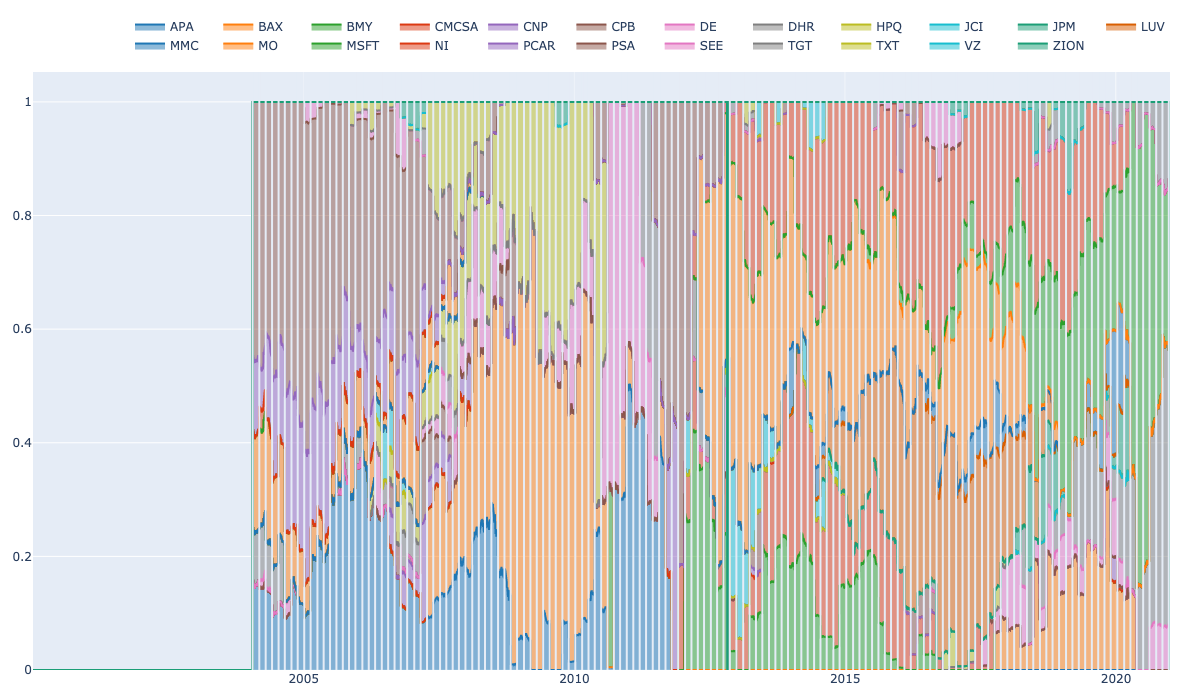

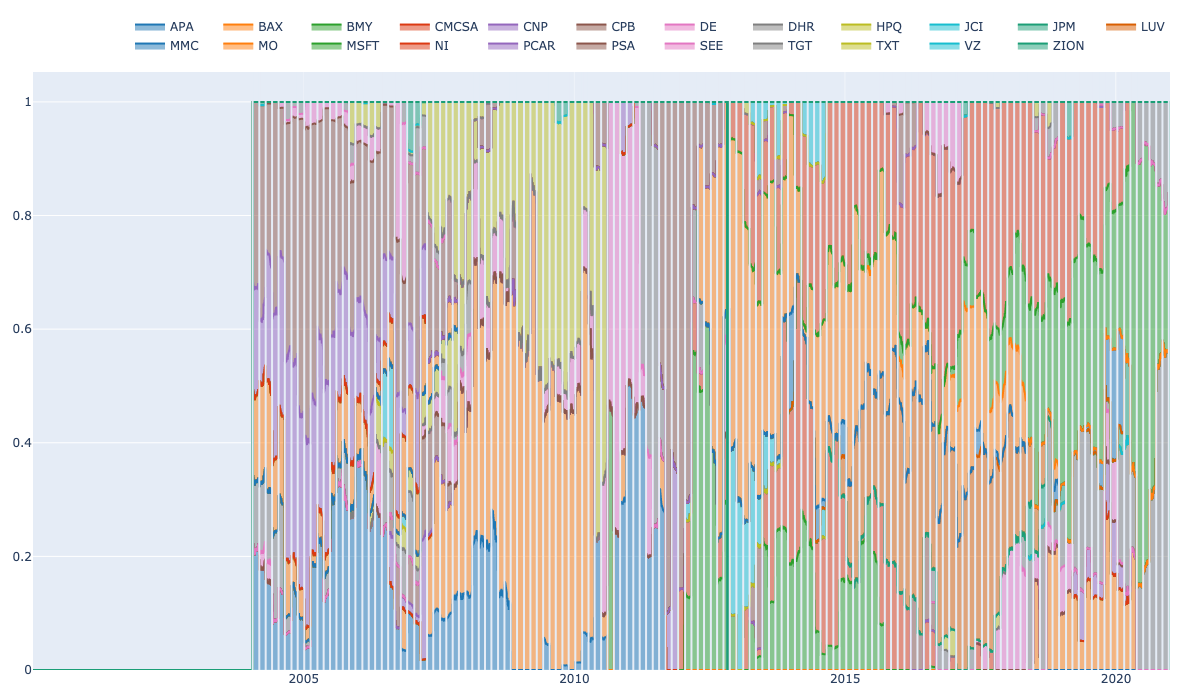

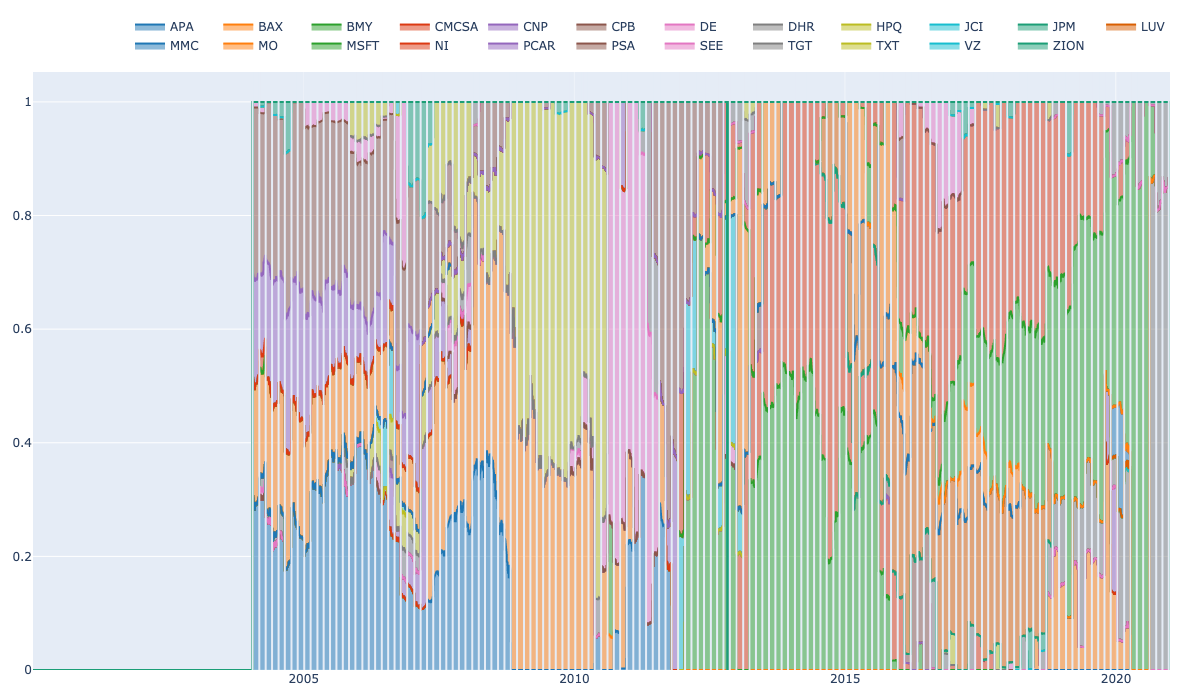

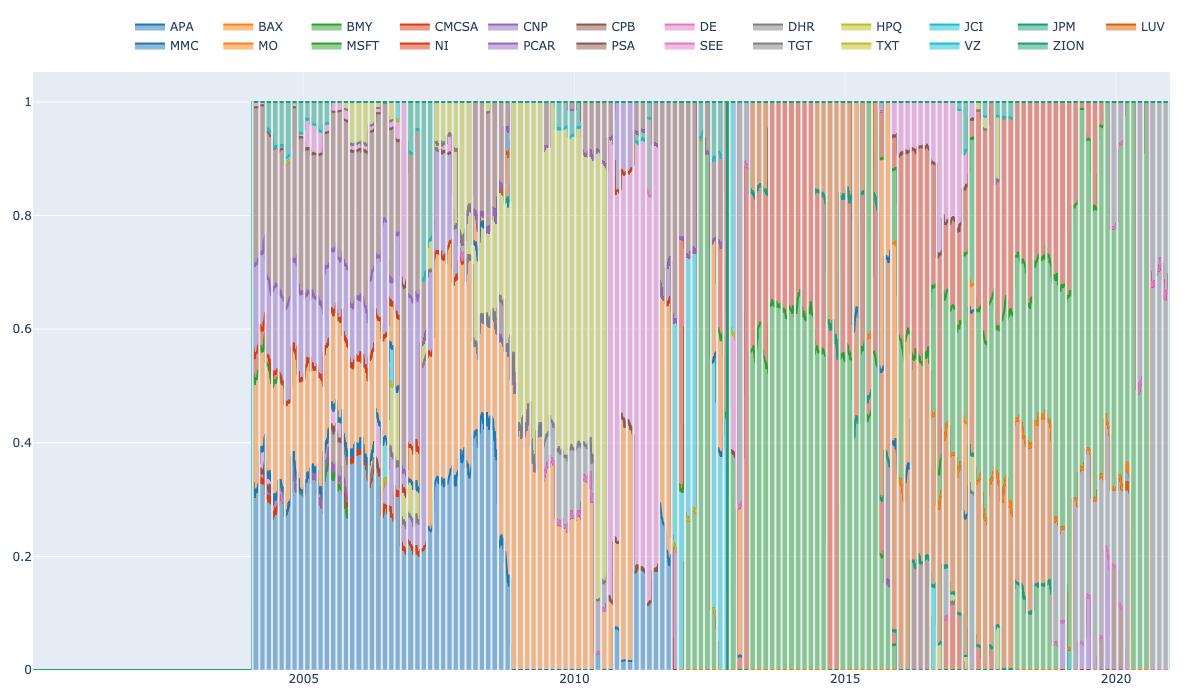

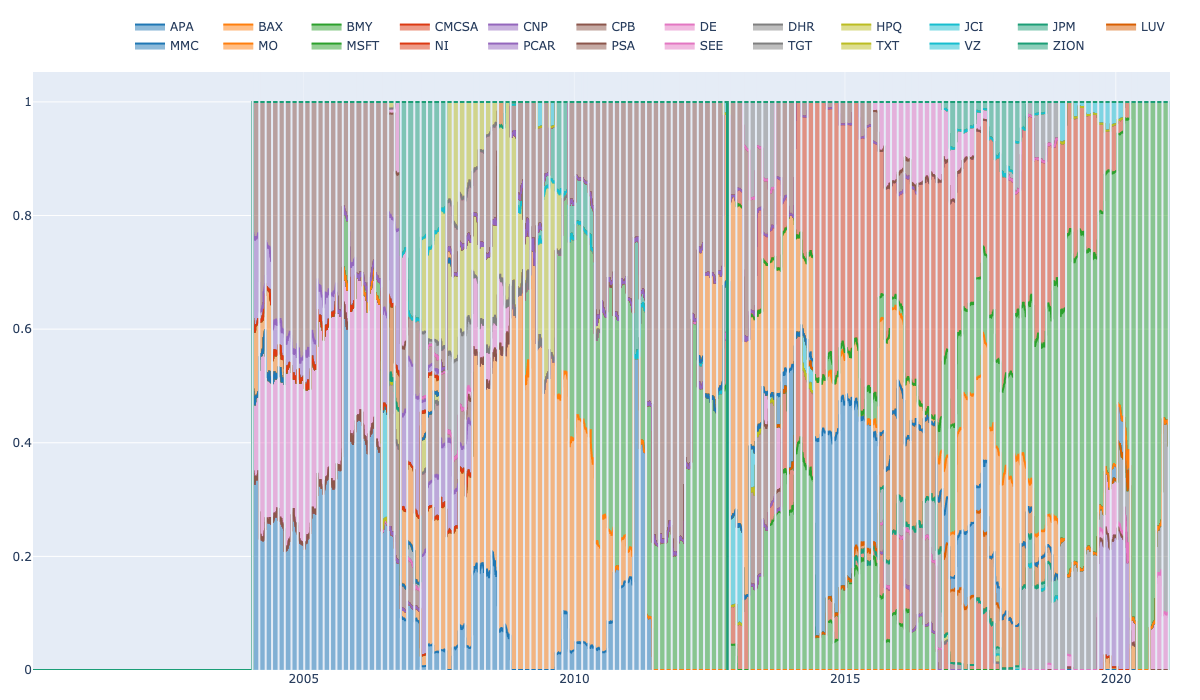

In [5]:
vbt.settings.layout['width'] = 1200
vbt.settings.layout['height'] = 700

def plot_allocation(rb_portfolio):
    # Plot weights development of the portfolio
    rb_holding_value = rb_portfolio.holding_value(group_by=False)
    rb_value = rb_portfolio.value()
    rb_idxs = np.flatnonzero((rb_portfolio.share_flow() != 0).any(axis=1))
    (rb_holding_value.vbt / rb_value).vbt.scatter(
        trace_names=assets,
        trace_kwargs=dict(
            stackgroup='one'
        ),
        shapes=[dict(
            xref='x',
            yref='paper',
            x0=date,
            x1=date,
            y0=0,
            y1=1,
            line_color=vbt.settings.layout['template']['layout']['plot_bgcolor']
        ) for date in data.index[rb_idxs]]
    ).show_png()
    
for i in rms:
    plot_allocation(portfolio[i])

### 3.3 Plotting Portfolio Values

<AxesSubplot:>

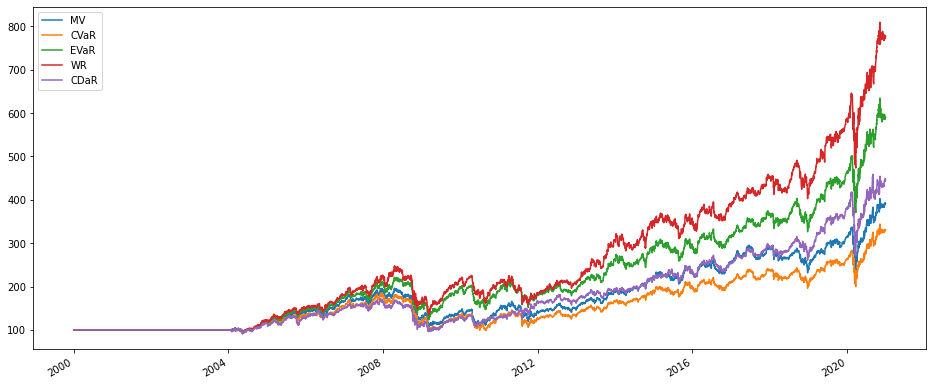

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,7))

values = pd.DataFrame([])
for i in rms:
    a = portfolio[i].value()
    values = pd.concat([values, a], axis=1)

values.columns = rms

values.plot(ax=ax)

### 3.4 Portfolio Stats

In [7]:
stats = pd.DataFrame([])
for i in rms:
    a = portfolio[i].stats()
    stats = pd.concat([stats, a], axis=1)

stats.columns = rms
display(stats)

,MV,CVaR,EVaR,WR,CDaR
Start,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00
End,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00,2020-12-30 00:00:00
Duration,5286 days 00:00:00,5286 days 00:00:00,5286 days 00:00:00,5286 days 00:00:00,5286 days 00:00:00
Init. Cash,100.000000,100.000000,100.000000,100.000000,100.000000
Total Profit,291.377769,230.721354,490.776918,677.090211,346.958127
Total Return [%],291.377769,230.721354,490.776918,677.090211,346.958127
Benchmark Return [%],332.546696,332.546696,332.546696,332.546696,332.546696
Position Coverage [%],80.703746,55.658096,80.062182,65.365444,78.009179
Max. Drawdown [%],44.847363,46.565035,44.150310,45.700976,44.234832
Avg. Drawdown [%],3.389656,3.689846,3.130560,2.934830,3.508129
